In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from pqcd.utils import (
    rcparams,
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    nsat
    )

from cmcrameri import cm

plt.rcParams.update(rcparams)

Get out low density values from the modified crust model

In [2]:
crust = pd.read_csv('../make-agnostic-processes/ingo-bps-with-cs2c2-modified.csv')

crust_pressure = to_GeV_per_cubic_femtometre(crust.pressurec2)
crust_energy_density = to_GeV_per_cubic_femtometre(crust.energy_densityc2)
crust_number_density = to_nucleons_per_cubic_femtometre(crust.baryon_density)
crust_chemical_potential = (crust_energy_density+crust_pressure)/crust_number_density

muL = crust_chemical_potential.iloc[-1]
nL = crust_number_density.iloc[-1]
pL = crust_pressure.iloc[-1]
epsilonL = crust_energy_density.iloc[-1]

Or from a $\chi \mathrm{EFT}$ prediction

In [3]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values for chiEFT
CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

muL, nL, pL = CET_values['soft']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

Get high density values from pQCD

In [4]:
X = 2
muH = 2.6
pQCDX = pqcd.pQCD(X)
nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
epsilonH = pqcd.epsilon_func(muH, nH, pH)

In [5]:
mu_array = np.linspace(muL, muH, 1000)

In [6]:
constraints = pqcd.constraints(muL, nL, pL, muH, nH, pH)

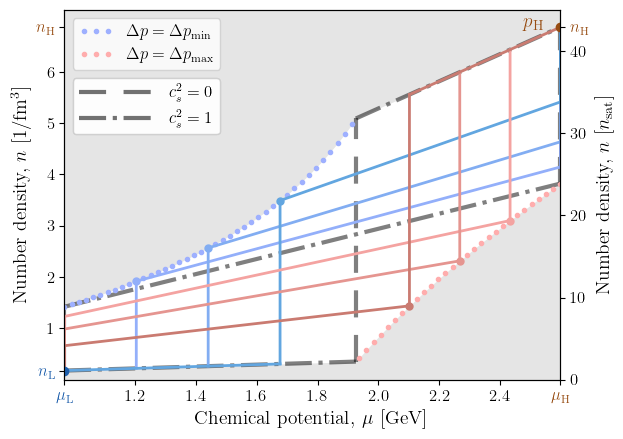

In [7]:
fig, ax = plt.subplots()

# Theory predictions
# ------------------

ax.plot(
    muL, 
    nL, 
    'o', 
    c=cm.roma(0.9), 
    zorder=10
    )

ax.plot(
    muH, 
    nH, 
    'o', 
    c=cm.roma(0.1), 
    zorder=10
    )

ylim = [0, ax.get_ylim()[1]]

ax.text(muH-0.06, nH+0.1, r'$p_\mathrm{H}$', va='center', ha='right', c=cm.roma(0.1))

# Constraints
# -----------

mu_dots = np.linspace(muL, muH, num=70)

ax.plot(
    mu_dots[mu_dots < constraints.muc], 
    constraints.nmax(mu_dots)[mu_dots < constraints.muc], 
    c=cm.berlin(0.), 
    alpha=1, 
    marker='o',
    markersize=3,
    lw=0,
    label='$\Delta p = \Delta p_\mathrm{min}$'
    )

ax.plot(
    mu_dots[mu_dots > constraints.muc], 
    constraints.nmin(mu_dots)[mu_dots > constraints.muc], 
    c=cm.berlin(1.), 
    alpha=1, 
    marker='o',
    markersize=3,
    lw=0,
    label='$\Delta p = \Delta p_\mathrm{max}$'
    )

ax.fill_between(
    mu_array, 
    constraints.nmin(mu_array), 
    ylim[0], 
    color='k', 
    alpha=0.1, 
    lw=0
)
ax.fill_between(
    mu_array, 
    constraints.nmax(mu_array), 
    ylim[1], 
    color='k', 
    alpha=0.1, 
    lw=0
)

# Critical EOSs
# -------------

lw = 3
alpha = 0.5

ax.plot(
    [muL, muL], 
    [nL, constraints.nmax(constraints.muL)], 
    c='k',
    ls='--',
    zorder=0.1,
    alpha=alpha,
    dashes=(6.5, 4.2),
    lw=lw,
    label='$c_s^2 = 0$'
    )

ax.plot(
    [muL, muH],
    [constraints.nmax(muL), constraints.nmin(muH)],
    c='k',
    ls='-.',
    zorder=0.1,
    alpha=alpha,
    lw=lw,
    label='$c_s^2 = 1$'
)

ax.plot(
    [muH, muH], 
    [constraints.nmin(constraints.muH), nH], 
    c='k',
    ls='--',
    zorder=0.1,
    alpha=alpha,
    dashes=(6.5, 4.2),
    lw=lw
    )

ax.plot(
    [muL, constraints.muc],
    [nL, constraints.nmin(constraints.muc)],
    c='k',
    ls='-.',
    zorder=0.1,
    alpha=alpha,
    lw=lw
)

ax.plot(
    [constraints.muc, constraints.muc], 
    [constraints.nmin(constraints.muc), constraints.nmax(constraints.muc)], 
    c='k',
    ls='--',
    zorder=0.1,
    alpha=alpha,
    dashes=(6.5, 4.2),
    lw=lw
    )

ax.plot(
    [constraints.muc, muH], 
    [constraints.nmax(constraints.muc), nH], 
    c='k',
    ls='-.',
    zorder=0.1,
    alpha=alpha,
    lw=lw
    )

# Minimum-pressure EOSs
# ---------------------

lw = 2

minp_n = 3
minp_cs = [cm.berlin(0.02), cm.berlin(0.05), cm.berlin(0.1), cm.berlin(0.15)]

minp_locs = [
    mu_dots[mu_dots < constraints.muc][
        (i*len(mu_dots[mu_dots < constraints.muc]))//(minp_n+1)
    ] for i in range(1, minp_n+1)]

for i, mu in enumerate(minp_locs):
    ax.plot(
        [mu, mu, muH, muH],
        [constraints.nmin(mu), constraints.nmax(mu), (constraints.nmax(mu)/mu)*muH, nH],
        c=minp_cs[i],
        lw=lw
    )

    if i == 0:
        ax.plot(
            [muH, muH], 
            [(constraints.nmax(mu)/mu)*muH, nH], 
            c=minp_cs[i],
            zorder=2, 
            lw=lw)
    elif i == minp_n-1:
        ax.plot([muL, mu], [nL, constraints.nmin(mu)], c=minp_cs[i], lw=lw)

    ax.plot(mu, constraints.nmax(mu), 'o', c=minp_cs[i], ms=5)

# Maximum-pressure EOSs
# ---------------------

maxp_n = 3
maxp_cs = [cm.berlin(1.-0.02), cm.berlin(1-0.05), cm.berlin(1-0.1), cm.berlin(1-0.15)]

maxp_locs = [
    mu_dots[mu_dots > constraints.muc][
        (i*len(mu_dots[mu_dots > constraints.muc]))//(maxp_n+1)
    ] for i in range(1, maxp_n+1)]

for i, mu in enumerate(maxp_locs[::-1]):
    ax.plot(
        [muL, muL, mu, mu],
        [nL, (constraints.nmin(mu)/mu)*muL, constraints.nmin(mu), constraints.nmax(mu)],
        c=maxp_cs[i],
        lw=lw
    )

    if i == maxp_n-1:
        ax.plot(
            [mu, muH], 
            [constraints.nmax(mu), nH], 
            c=maxp_cs[i], 
            lw=lw, 
            zorder=5
            )
    elif i == 0:
        ax.plot([muL, muL], [nL, (constraints.nmin(mu)/mu)*muL], c=maxp_cs[i], lw=lw)

    ax.plot(mu, constraints.nmin(mu), 'o', c=maxp_cs[i], ms=5)

# ---

ax.set_ylabel(r'Number density, $n$ [1/fm$^3$]')

ax.set_xlabel(r'Chemical potential, $\mu$ [GeV]')
ax.set_xlim(constraints.muL, constraints.muH)
ax.set_ylim(ylim)

ax.set_xticks([muL, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, muH])
ax.set_xticklabels(['$\mu_\mathrm{L}$', 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, '$\mu_\mathrm{H}$'])

for i, xtick in enumerate(ax.get_xticklabels()):
    if i == 0:
        xtick.set_color(cm.roma(0.9))
    elif i == 8:
        xtick.set_color(cm.roma(0.1))

ax.set_yticks([nL, 1, 2, 3, 4, 5, 6, nH])
ax.set_yticklabels(['$n_\mathrm{L}$', 1, 2, 3, 4, 5, 6, '$n_\mathrm{H}$'])
for i, ytick in enumerate(ax.get_yticklabels()):
    if i == 0:
        ytick.set_color(cm.roma(0.9))
    elif i == 7:
        ytick.set_color(cm.roma(0.1))

# ---

twinx = ax.twinx()
twinx.set_ylim(np.array(ax.get_ylim())/nsat)
twinx.set_ylabel(r'Number density, $n\ [n_\mathrm{sat}]$')

twinx.set_yticks([0, 10, 20, 30, 40, nH/nsat])
twinx.set_yticklabels([0, 10, 20, 30, 40, '$n_\mathrm{H}$'])
for i, ytick in enumerate(twinx.get_yticklabels()):
    if i == 5:
        ytick.set_color(cm.roma(0.1))

custom_handles = [
    plt.Line2D([0],[0],c=cm.berlin(0.),marker='o',markersize=3,lw=0,),
    plt.Line2D([0],[0],c=cm.berlin(1.),marker='o',markersize=3,lw=0,),
    # plt.Line2D([0],[0],c='k',ls='--',alpha=0.5,dashes=(3, 4.2),lw=3,)
]

custom_labels = [
    '$\Delta p = \Delta p_\mathrm{min}$',
    '$\Delta p = \Delta p_\mathrm{max}$',
    # '$c_s^2 = 0$'
]

l1 = ax.legend(
    custom_handles,
    custom_labels,
    loc='upper left',
    numpoints=3,
    # handlelength=4,
    # handletextpad=0.1
    )

ax.add_artist(l1)

custom_handles = [
    plt.Line2D([0],[0],c='k',ls='--',alpha=0.5,dashes=(6.5, 4.2),lw=3,),
    plt.Line2D([0],[0],c='k',ls='-',alpha=0.5,dashes=[6.5, 1.6, 1, 1.6],lw=3,)
]

custom_labels = [
    '$c_s^2 = 0$',
    '$c_s^2 = 1$'
]

l2 = ax.legend(
    custom_handles,
    custom_labels,
    loc='upper left',
    handlelength=4.6,
    # handletextpad=0.1,
    bbox_to_anchor=(0,0.838)
    )

ax.add_artist(l2)

fig.savefig('figures/paper/constraint_construction.pdf', bbox_inches='tight')

In [8]:
from operator import sub

def get_aspect(ax):
    # Function used when converting line derivative to rotation angle for the 
    # text labels
    # https://stackoverflow.com/questions/41597177/get-aspect-ratio-of-axes
    
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

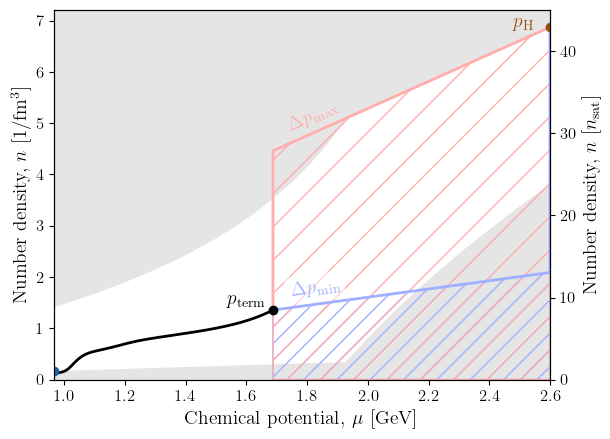

In [9]:
fig, ax = plt.subplots()

# Theory predictions
# ------------------

ax.plot(
    muL, 
    nL, 
    'o', 
    c=cm.roma(0.9), 
    zorder=10
    )

ax.plot(
    muH, 
    nH, 
    'o', 
    c=cm.roma(0.1), 
    zorder=10
    )

ylim = [0, ax.get_ylim()[1]]

ax.text(muH-0.06, nH+0.1, r'$p_\mathrm{H}$', va='center', ha='right', c=cm.roma(0.1))

# Constraints
# -----------

ax.fill_between(mu_array, constraints.nmin(mu_array), ylim[0], color='k', alpha=0.1, lw=0)
ax.fill_between(mu_array, constraints.nmax(mu_array), ylim[1], color='k', alpha=0.1, lw=0)

# Example EOS
# -----------

eos_number = 24

collated_eos = pd.read_csv('../data/eos-draws-modified-12.csv')

ntov = to_nucleons_per_cubic_femtometre(collated_eos.iloc[eos_number]['rhoc(M@Mmax)'])

file_path = f'../data/eos-draws-modified/12/margagn/DRAWmod1000-000000/eos-draw-{eos_number:06}.csv'
eos = pd.read_csv(file_path)

eos_pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
eos_energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
eos_number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)
eos_chemical_potential = (eos_energy_density+eos_pressure)/eos_number_density

plot_mask = eos_number_density < ntov

ax.plot(
    eos_chemical_potential[plot_mask], 
    eos_number_density[plot_mask],
    c='k',
    lw=2
    )

mu0 = eos_chemical_potential[plot_mask].values[-1]
n0 = eos_number_density[plot_mask].values[-1]
p0 = eos_pressure[plot_mask].values[-1]

ax.plot(mu0, n0, 'o', c='k', zorder=10)

ax.text(mu0-0.03, n0+0.2, r'$p_\mathrm{term}$', va='center', ha='right', c='k')


# Minimum-pressure EOS
# --------------------

lw = 2

minp_c = cm.berlin(0.0)

ax.plot(
    [mu0, muH, muH],
    [n0, (n0/mu0)*muH, nH],
    c=minp_c,
    lw=lw
)

ax.fill_between(
    mu_array[mu_array > mu0],
    0,
    (n0/mu0)*mu_array[mu_array > mu0],
    facecolor='none', 
    hatch='//', 
    edgecolor=minp_c
)

aspect = get_aspect(ax)

ax.text(
    1.75,
    (n0/mu0)*1.75+0.15,
    '$\Delta p_\mathrm{min}$',
    va='bottom',
    c=minp_c,
    bbox=dict(facecolor='w', alpha=0.5, lw=0),
    rotation=(180/np.pi)*np.arctan((n0/mu0)*aspect),
    rotation_mode='anchor'
)

# Maximum-pressure EOS
# --------------------

lw = 2

maxp_c = cm.berlin(1.0)

ax.plot(
    [mu0, mu0, muH],
    [n0, (nH/muH)*mu0, nH],
    c=maxp_c,
    lw=lw
)

ax.fill_between(
    mu_array[mu_array > mu0],
    0,
    (nH/muH)*mu_array[mu_array > mu0],
    facecolor='none', 
    hatch='/', 
    edgecolor=maxp_c,
    label='$\Delta p_\mathrm{max}$'
)

ax.text(
    1.75,
    (nH/muH)*1.75+0.15,
    '$\Delta p_\mathrm{max}$',
    va='bottom',
    c=maxp_c,
    rotation=(180/np.pi)*np.arctan((nH/muH)*aspect),
    rotation_mode='anchor'
)

# ---

ax.set_xlabel(r'Chemical potential, $\mu$ [GeV]')
ax.set_ylabel(r'Number density, $n$ [1/fm$^3$]')

ax.set_xlim(constraints.muL, constraints.muH)
ax.set_ylim(ylim)

# ---

twinx = ax.twinx()
twinx.set_ylim(np.array(ax.get_ylim())/nsat)
twinx.set_ylabel(r'Number density, $n\ [n_\mathrm{sat}]$')

fig.savefig('figures/paper/constraint_application.pdf', bbox_inches='tight')

In [10]:
collated_eos = pd.read_csv('../data/eos-draws-modified-12.csv')

In [11]:
ntov_list = []
for i in range(1000):
    ntov_list.append(to_nucleons_per_cubic_femtometre(collated_eos.iloc[i]['rhoc(M@Mmax)'])/nsat)

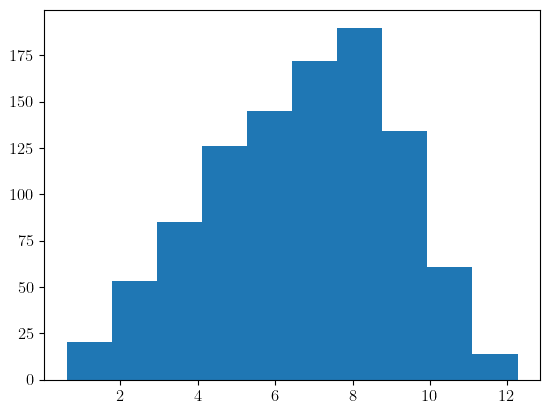

In [12]:
fig, ax = plt.subplots()
ax.hist(ntov_list);

In [13]:
np.where(np.array(ntov_list) > 8)

(array([  8,  10,  14,  19,  21,  24,  25,  27,  28,  30,  34,  35,  37,
         38,  39,  40,  41,  47,  48,  50,  52,  53,  54,  55,  56,  58,
         61,  62,  63,  68,  72,  74,  75,  77,  79,  86,  88,  89,  93,
         94,  95,  99, 104, 106, 107, 109, 112, 113, 118, 121, 122, 124,
        125, 126, 132, 138, 139, 140, 143, 146, 152, 155, 156, 158, 160,
        161, 163, 166, 167, 170, 171, 172, 174, 175, 176, 178, 182, 183,
        184, 188, 191, 197, 199, 200, 203, 205, 208, 209, 213, 215, 218,
        221, 222, 224, 225, 229, 231, 233, 236, 243, 244, 246, 250, 251,
        253, 255, 256, 257, 260, 261, 262, 263, 264, 265, 269, 274, 275,
        277, 278, 279, 282, 289, 295, 297, 301, 303, 305, 306, 307, 310,
        314, 315, 316, 318, 319, 320, 322, 326, 327, 329, 330, 333, 334,
        336, 339, 345, 346, 347, 353, 355, 357, 365, 366, 368, 370, 374,
        376, 381, 387, 388, 389, 391, 394, 397, 398, 399, 402, 403, 404,
        406, 408, 411, 415, 416, 417, 418, 420, 421

In [22]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

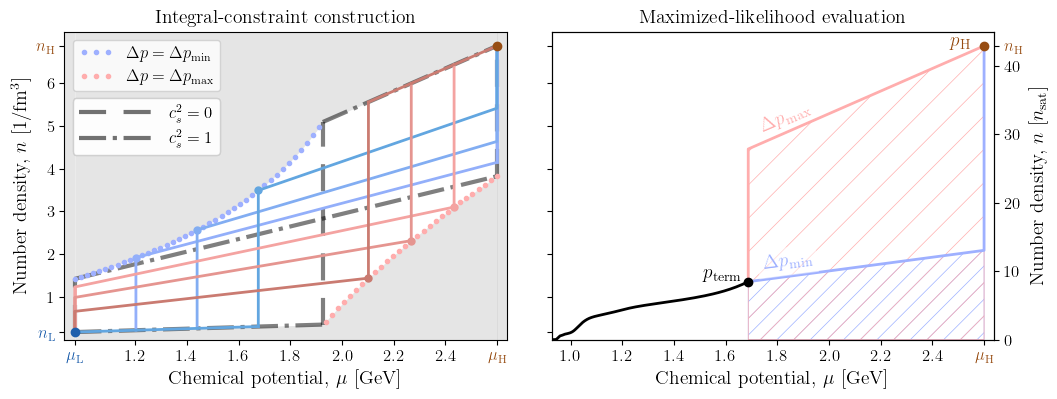

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

# Theory predictions
# ------------------

axs[0].plot(
    muL, 
    nL, 
    'o', 
    c=cm.roma(0.9), 
    zorder=10
    )

for ax in axs:

    ax.plot(
        muH, 
        nH, 
        'o', 
        c=cm.roma(0.1), 
        zorder=10
        )

    ylim = [0, ax.get_ylim()[1]]

axs[1].text(muH-0.06, nH+0.1, r'$p_\mathrm{H}$', va='center', ha='right', c=cm.roma(0.1))

# Constraints
# -----------

mu_dots = np.linspace(muL, muH, num=70)

axs[0].plot(
    mu_dots[mu_dots < constraints.muc], 
    constraints.nmax(mu_dots)[mu_dots < constraints.muc], 
    c=cm.berlin(0.), 
    alpha=1, 
    marker='o',
    markersize=3,
    lw=0,
    label='$\Delta p = \Delta p_\mathrm{min}$'
    )

axs[0].plot(
    mu_dots[mu_dots > constraints.muc], 
    constraints.nmin(mu_dots)[mu_dots > constraints.muc], 
    c=cm.berlin(1.), 
    alpha=1, 
    marker='o',
    markersize=3,
    lw=0,
    label='$\Delta p = \Delta p_\mathrm{max}$'
    )

axs[0].fill_between(
    mu_array, 
    constraints.nmin(mu_array), 
    ylim[0], 
    color='k', 
    alpha=0.1, 
    lw=0
)
axs[0].fill_between(
    mu_array, 
    constraints.nmax(mu_array), 
    ylim[1], 
    color='k', 
    alpha=0.1, 
    lw=0
)

axs[0].fill_between(
    np.linspace(0, muL, 2),
    ylim[0],
    ylim[1],
    color='k', 
    alpha=0.1, 
    lw=0
)

axs[0].fill_between(
    np.linspace(muH, 3, 2),
    ylim[0],
    ylim[1],
    color='k', 
    alpha=0.1, 
    lw=0
)

# Critical EOSs
# -------------

lw = 3
alpha = 0.5

axs[0].plot(
    [muL, muL], 
    [nL, constraints.nmax(constraints.muL)], 
    c='k',
    ls='--',
    zorder=0.1,
    alpha=alpha,
    dashes=(6.5, 4.2),
    lw=lw,
    label='$c_s^2 = 0$'
    )

axs[0].plot(
    [muL, muH],
    [constraints.nmax(muL), constraints.nmin(muH)],
    c='k',
    ls='-.',
    zorder=0.1,
    alpha=alpha,
    lw=lw,
    label='$c_s^2 = 1$'
)

axs[0].plot(
    [muH, muH], 
    [constraints.nmin(constraints.muH), nH], 
    c='k',
    ls='--',
    zorder=0.1,
    alpha=alpha,
    dashes=(6.5, 4.2),
    lw=lw
    )

axs[0].plot(
    [muL, constraints.muc],
    [nL, constraints.nmin(constraints.muc)],
    c='k',
    ls='-.',
    zorder=0.1,
    alpha=alpha,
    lw=lw
)

axs[0].plot(
    [constraints.muc, constraints.muc], 
    [constraints.nmin(constraints.muc), constraints.nmax(constraints.muc)], 
    c='k',
    ls='--',
    zorder=0.1,
    alpha=alpha,
    dashes=(6.5, 4.2),
    lw=lw
    )

axs[0].plot(
    [constraints.muc, muH], 
    [constraints.nmax(constraints.muc), nH], 
    c='k',
    ls='-.',
    zorder=0.1,
    alpha=alpha,
    lw=lw
    )

# Example EOS
# -----------

eos_number = 24

collated_eos = pd.read_csv('../data/eos-draws-modified-12.csv')

ntov = to_nucleons_per_cubic_femtometre(collated_eos.iloc[eos_number]['rhoc(M@Mmax)'])

file_path = f'../data/eos-draws-modified/12/margagn/DRAWmod1000-000000/eos-draw-{eos_number:06}.csv'
eos = pd.read_csv(file_path)

eos_pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
eos_energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
eos_number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)
eos_chemical_potential = (eos_energy_density+eos_pressure)/eos_number_density

plot_mask = eos_number_density < ntov

axs[1].plot(
    eos_chemical_potential[plot_mask], 
    eos_number_density[plot_mask],
    c='k',
    lw=2
    )

mu0 = eos_chemical_potential[plot_mask].values[-1]
n0 = eos_number_density[plot_mask].values[-1]
p0 = eos_pressure[plot_mask].values[-1]

axs[1].plot(mu0, n0, 'o', c='k', zorder=10)

axs[1].text(mu0-0.03, n0+0.2, r'$p_\mathrm{term}$', va='center', ha='right', c='k')

# Minimum-pressure EOS
# --------------------

lw = 2

minp_c = cm.berlin(0.0)

axs[1].plot(
    [mu0, muH, muH],
    [n0, (n0/mu0)*muH, nH],
    c=minp_c,
    lw=lw
)

axs[1].fill_between(
    mu_array[mu_array > mu0],
    0,
    (n0/mu0)*mu_array[mu_array > mu0],
    facecolor='none', 
    hatch='//', 
    edgecolor=minp_c,
    linewidth=0.5
    # alpha=0.5
)

aspect = get_aspect(ax)

axs[1].text(
    1.75,
    (n0/mu0)*1.75+0.15,
    '$\Delta p_\mathrm{min}$',
    va='bottom',
    c=cm.berlin(0.0),
    bbox=dict(facecolor='w', alpha=0.5, lw=0),
    rotation=(180/np.pi)*np.arctan((n0/mu0)*aspect),
    rotation_mode='anchor'
)

# Maximum-pressure EOS
# --------------------

lw = 2

maxp_c = cm.berlin(1.0)

axs[1].plot(
    [mu0, mu0, muH],
    [n0, (nH/muH)*mu0, nH],
    c=maxp_c,
    lw=lw
)

axs[1].fill_between(
    mu_array[mu_array > mu0],
    0,
    (nH/muH)*mu_array[mu_array > mu0],
    facecolor='none', 
    hatch='/', 
    edgecolor=maxp_c,
    label='$\Delta p_\mathrm{max}$',
    linewidth=0.5
    # alpha=0.5
)

axs[1].text(
    1.75,
    (nH/muH)*1.75+0.15,
    '$\Delta p_\mathrm{max}$',
    va='bottom',
    c=cm.berlin(1.0),
    rotation=(180/np.pi)*np.arctan((nH/muH)*aspect),
    rotation_mode='anchor'
)

# Minimum-pressure EOSs
# ---------------------

lw = 2

minp_n = 3
minp_cs = [cm.berlin(0.02), cm.berlin(0.05), cm.berlin(0.1), cm.berlin(0.15)]

minp_locs = [
    mu_dots[mu_dots < constraints.muc][
        (i*len(mu_dots[mu_dots < constraints.muc]))//(minp_n+1)
    ] for i in range(1, minp_n+1)]

for i, mu in enumerate(minp_locs):
    axs[0].plot(
        [mu, mu, muH, muH],
        [constraints.nmin(mu), constraints.nmax(mu), (constraints.nmax(mu)/mu)*muH, nH],
        c=minp_cs[i],
        lw=lw
    )

    if i == 0:
        axs[0].plot(
            [muH, muH], 
            [(constraints.nmax(mu)/mu)*muH, nH], 
            c=minp_cs[i],
            zorder=2, 
            lw=lw)
    elif i == minp_n-1:
        axs[0].plot([muL, mu], [nL, constraints.nmin(mu)], c=minp_cs[i], lw=lw)

    axs[0].plot(mu, constraints.nmax(mu), 'o', c=minp_cs[i], ms=5)

# Maximum-pressure EOSs
# ---------------------

maxp_n = 3
maxp_cs = [cm.berlin(1.-0.02), cm.berlin(1-0.05), cm.berlin(1-0.1), cm.berlin(1-0.15)]

maxp_locs = [
    mu_dots[mu_dots > constraints.muc][
        (i*len(mu_dots[mu_dots > constraints.muc]))//(maxp_n+1)
    ] for i in range(1, maxp_n+1)]

for i, mu in enumerate(maxp_locs[::-1]):
    axs[0].plot(
        [muL, muL, mu, mu],
        [nL, (constraints.nmin(mu)/mu)*muL, constraints.nmin(mu), constraints.nmax(mu)],
        c=maxp_cs[i],
        lw=lw
    )

    if i == maxp_n-1:
        axs[0].plot(
            [mu, muH], 
            [constraints.nmax(mu), nH], 
            c=maxp_cs[i], 
            lw=lw, 
            zorder=5
            )
    elif i == 0:
        axs[0].plot([muL, muL], [nL, (constraints.nmin(mu)/mu)*muL], c=maxp_cs[i], lw=lw)

    axs[0].plot(mu, constraints.nmin(mu), 'o', c=maxp_cs[i], ms=5)

# ---

axs[0].set_ylabel(r'Number density, $n$ [1/fm$^3$]')

for ax in axs:
    ax.set_xlabel(r'Chemical potential, $\mu$ [GeV]')
    ax.set_xlim(constraints.muL-0.04, constraints.muH+0.04)
    ax.set_ylim(ylim)

axs[0].set_xticks([muL, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, muH])
axs[0].set_xticklabels(['$\mu_\mathrm{L}$', 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, '$\mu_\mathrm{H}$'])

for i, xtick in enumerate(axs[0].get_xticklabels()):
    if i == 0:
        xtick.set_color(cm.roma(0.9))
    elif i == 8:
        xtick.set_color(cm.roma(0.1))

axs[1].set_xticks([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, muH])
axs[1].set_xticklabels([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, '$\mu_\mathrm{H}$'])

for i, xtick in enumerate(axs[1].get_xticklabels()):
    if i == 8:
        xtick.set_color(cm.roma(0.1))

axs[0].set_yticks([nL, 1, 2, 3, 4, 5, 6, nH])
axs[0].set_yticklabels(['$n_\mathrm{L}$', 1, 2, 3, 4, 5, 6, '$n_\mathrm{H}$'])
for i, ytick in enumerate(axs[0].get_yticklabels()):
    if i == 0:
        ytick.set_color(cm.roma(0.9))
    elif i == 7:
        ytick.set_color(cm.roma(0.1))

# ---

twinx = axs[1].twinx()
twinx.set_ylim(np.array(axs[1].get_ylim())/nsat)
twinx.set_ylabel(r'Number density, $n\ [n_\mathrm{sat}]$')

twinx.set_yticks([0, 10, 20, 30, 40, nH/nsat])
twinx.set_yticklabels([0, 10, 20, 30, 40, '$n_\mathrm{H}$'])
for i, ytick in enumerate(twinx.get_yticklabels()):
    if i == 5:
        ytick.set_color(cm.roma(0.1))

custom_handles = [
    plt.Line2D([0],[0],c=cm.berlin(0.),marker='o',markersize=3,lw=0,),
    plt.Line2D([0],[0],c=cm.berlin(1.),marker='o',markersize=3,lw=0,),
    # plt.Line2D([0],[0],c='k',ls='--',alpha=0.5,dashes=(3, 4.2),lw=3,)
]

custom_labels = [
    '$\Delta p = \Delta p_\mathrm{min}$',
    '$\Delta p = \Delta p_\mathrm{max}$',
    # '$c_s^2 = 0$'
]

l1 = axs[0].legend(
    custom_handles,
    custom_labels,
    loc='upper left',
    numpoints=3,
    # handlelength=4,
    # handletextpad=0.1
    )

axs[0].add_artist(l1)

custom_handles = [
    plt.Line2D([0],[0],c='k',ls='--',alpha=0.5,dashes=(6.5, 4.2),lw=3,),
    plt.Line2D([0],[0],c='k',ls='-',alpha=0.5,dashes=[6.5, 1.6, 1, 1.6],lw=3,)
]

custom_labels = [
    '$c_s^2 = 0$',
    '$c_s^2 = 1$'
]

l2 = axs[0].legend(
    custom_handles,
    custom_labels,
    loc='upper left',
    handlelength=4.6,
    # handletextpad=0.1,
    bbox_to_anchor=(0,0.81)
    )

axs[0].add_artist(l2)

axs[0].set_title('Integral-constraint construction')
axs[1].set_title('Maximized-likelihood evaluation')

fig.savefig('figures/paper/constraint_construction_evaluation.pdf', bbox_inches='tight')